In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from getpass import getpass
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Connection parameters to PostgreSQL
DB_USER = "postgres"         
DB_PASSWORD = getpass()
DB_HOST = "localhost"         
DB_PORT = "5432"             
DB_NAME = "ecommerce"         

# Create connection
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

 ········


In [3]:
df = pd.read_sql('''
SELECT *
FROM order_sample_ready_to_ml_features_fixed
''', engine).astype(float)

df.delivery_time = df.delivery_time.clip(lower=0)
df.estimated_delivery_days = df.estimated_delivery_days.clip(lower=0)

df.head()

,category_share_other_category_sum,sel2cust_dist,category_count_moveis_decoracao_sum,avg_review_score_bin,product_width_cm_min,category_share_utilidades_domesticas_sum,category_share_informatica_acessorios_sum,product_height_cm_min,category_count_beleza_saude_sum,product_name_lenght_std,...,payment_installments,category_count_telefonia_sum,estimated_delivery_days,category_count_esporte_lazer_sum,category_count_cama_mesa_banho_sum,price_min,category_count_other_category_sum,freight_value_min,category_count_automotivo_sum,delivery_time
0,1.0,0.000000,0.0,2.0,14.0,0.0,0.0,9.0,0.0,0.0,...,2.0,0.0,15.0,0.0,0.0,58.90,1.0,13.29,0.0,7.0
1,1.0,5.510120,0.0,1.0,40.0,0.0,0.0,30.0,0.0,0.0,...,3.0,0.0,18.0,0.0,0.0,239.90,1.0,19.93,0.0,16.0
2,0.0,2.865357,1.0,1.0,33.0,0.0,0.0,13.0,0.0,0.0,...,5.0,0.0,21.0,0.0,0.0,199.00,0.0,17.87,0.0,8.0
3,1.0,2.652272,0.0,1.0,15.0,0.0,0.0,10.0,0.0,0.0,...,2.0,0.0,11.0,0.0,0.0,12.99,1.0,12.79,0.0,6.0
4,0.0,6.316069,0.0,1.0,30.0,0.0,0.0,40.0,0.0,0.0,...,3.0,0.0,40.0,0.0,0.0,199.90,0.0,18.14,0.0,25.0


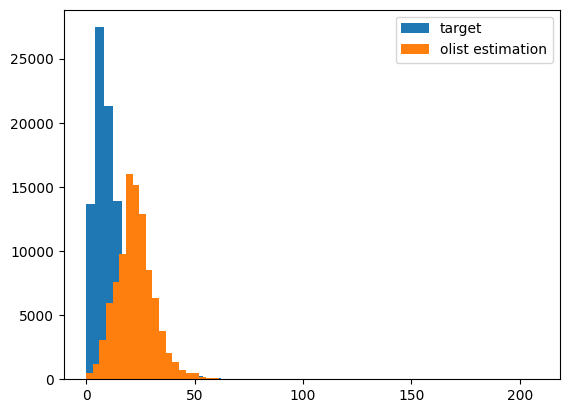

MAE (original space): 12.4753
MSE (original space): 221.9602
RMSE (original space): 14.8983
R² Score (log space): -1.0506


In [4]:
# Metrics for current olist delivery time prediction (estimated_delivery_days)

plt.hist(df.delivery_time, bins=50, label='target')
plt.hist(df.estimated_delivery_days, bins=50, label='olist estimation')
plt.legend()
plt.show()

mae = mean_absolute_error(df.delivery_time, df.estimated_delivery_days)
mse = mean_squared_error(df.delivery_time, df.estimated_delivery_days)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+df.delivery_time), np.log(1 + df.estimated_delivery_days))
print(f"MAE (original space): {mae:.4f}")
print(f"MSE (original space): {mse:.4f}")
print(f"RMSE (original space): {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

### Default delivery time estimation by Olist is awful(

# Let's try linear regression first

Metrics Train (Linear Regression):
MAE: 5.2555
MSE: 71.9128
RMSE: 8.4801
R² Score: 0.3117

Metrics Test (Linear Regression):
MAE: 5.2162
MSE: 66.7720
RMSE: 8.1714
R² Score: 0.3135


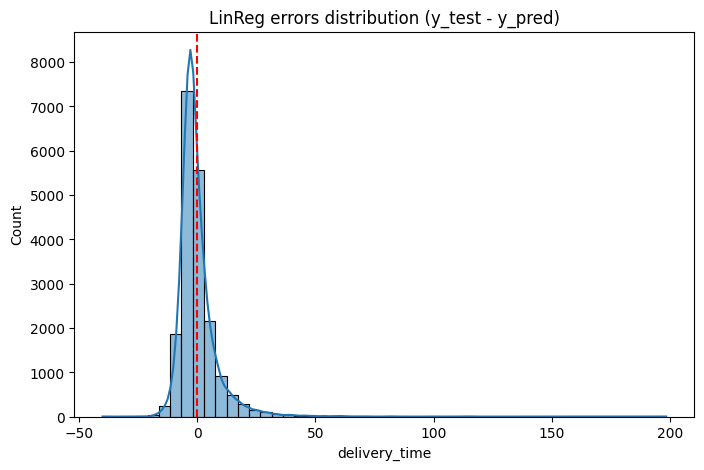

In [5]:
from sklearn.linear_model import LinearRegression


X = df.drop(columns=["delivery_time"]) 
y = df["delivery_time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = np.clip(model.predict(X_train), a_min=0, a_max=None)

mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_train), np.log(1+y_pred))

print(f"Metrics Train (Linear Regression):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

y_pred = np.clip(model.predict(X_test), a_min=0, a_max=None)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_test), np.log(1+y_pred))

print(f"\nMetrics Test (Linear Regression):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Errors distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_test - y_pred, bins=50, kde=True)
plt.axvline(0, color="red", linestyle="dashed")
plt.title("LinReg errors distribution (y_test - y_pred)")
plt.show()


### Better than current estimation by Olist, but far from ideal. Let's try logarithm target

Metrics Train (Log-Transformed Linear Regression):
MAE (original space): 5.1755
MSE (original space): 82.4684
RMSE (original space): 9.0812
R² Score (log space): 0.3346

Metrics Test (Log-Transformed Linear Regression):
MAE (original space): 5.1366
MSE (original space): 76.1233
RMSE (original space): 8.7249
R² Score (log space): 0.3336


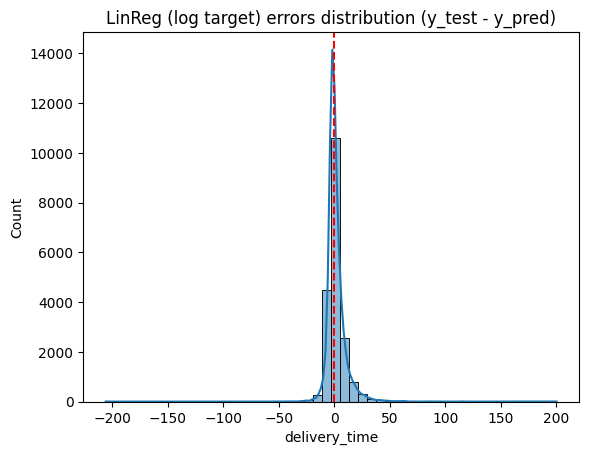

In [6]:
# Logarithm target 
df["log_delivery_time"] = np.log(1 + df["delivery_time"])  

df = df.dropna(subset=["log_delivery_time"])

X = df.drop(columns=["delivery_time", "log_delivery_time"]) 
y = df["log_delivery_time"]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions on train
y_pred_log = model.predict(X_train)
y_pred = np.exp(y_pred_log) - 1  # Back to original space from logarithmic

# Metrics on train
mae = mean_absolute_error(np.exp(y_train) - 1, y_pred)
mse = mean_squared_error(np.exp(y_train) - 1, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_log)

print(f"Metrics Train (Log-Transformed Linear Regression):")
print(f"MAE (original space): {mae:.4f}")
print(f"MSE (original space): {mse:.4f}")
print(f"RMSE (original space): {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

# Predictions on test
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1  # Back to original space from logarithmic

# Metrics on test
mae = mean_absolute_error(np.exp(y_test) - 1, y_pred)
mse = mean_squared_error(np.exp(y_test) - 1, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_log)

print(f"\nMetrics Test (Log-Transformed Linear Regression):")
print(f"MAE (original space): {mae:.4f}")
print(f"MSE (original space): {mse:.4f}")
print(f"RMSE (original space): {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

# Errors distribution (original non-logarithmic space)
errors = np.exp(y_test) - 1 - y_pred
sns.histplot(errors, bins=50, kde=True)
plt.axvline(x=0, color='r', linestyle='dashed')
plt.xlabel("delivery_time")
plt.title("LinReg (log target) errors distribution (y_test - y_pred)")
plt.show()


### RMSE became worse even though R2 and MAE increased a little bit. No logarithming then.

In [7]:
X = df.drop(columns=["delivery_time", "log_delivery_time"]) ]
y = df["delivery_time"]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try Ridge

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Лучший alpha для Ridge: 339.3221771895323
Metrics Train (Ridge):
MAE: 5.2552
MSE: 71.9142
RMSE: 8.4802
R² Score (log space): 0.3117

Metrics Test (Ridge):
MAE: 5.2158
MSE: 66.7762
RMSE: 8.1717
R² Score (log space): 0.3136


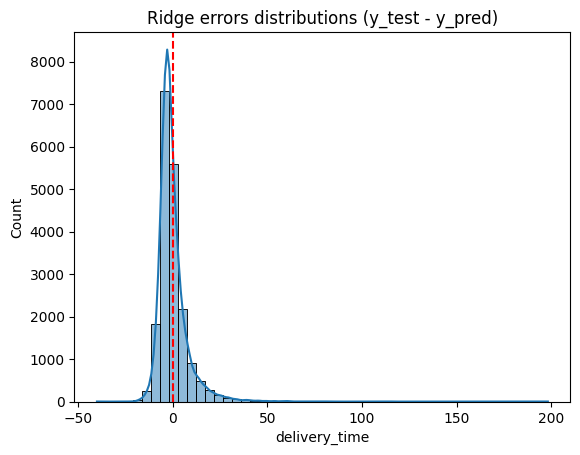

In [8]:
from sklearn.linear_model import RidgeCV, Ridge

alphas = np.logspace(-4, 4, 50)

ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

best_alpha = ridge_cv.alpha_
print(f"Лучший alpha для Ridge: {best_alpha}")

# Train with best alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)

# Train
y_pred = np.clip(ridge.predict(X_train), a_min=0, a_max=None)

mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_train), np.log(1+y_pred))

print(f"Metrics Train (Ridge):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

# Test
y_pred = np.clip(ridge.predict(X_test), a_min=0, a_max=None)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_test), np.log(1+y_pred))

print(f"\nMetrics Test (Ridge):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

# Errors distribution
errors = y_test - y_pred
sns.histplot(errors, bins=50, kde=True)
plt.axvline(x=0, color='r', linestyle='dashed')
plt.xlabel("delivery_time")
plt.title("Ridge errors distributions (y_test - y_pred)")
plt.show()


### Not better than LinReg. Try Lasso

In [9]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Data standartizaion
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Find best alpha
lasso = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print(f"Best alpha: {best_alpha}")

# Train
y_pred = np.clip(lasso.predict(X_train_scaled), a_min=0, a_max=None)

mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_train), np.log(1+y_pred))

print(f"Metrics Train (Lasso Regression):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

# Test
y_pred = np.clip(lasso.predict(X_test_scaled), a_min=0, a_max=None)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_test), np.log(1+y_pred))

print(f"\nMetrics Test (Lasso Regression):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

# Features left
selected_features = np.array(X_train.columns)[lasso.coef_ != 0]
print(f"Number of features selected: {len(selected_features)}")
print(f"Features selected: {selected_features}")


Лучший alpha для Lasso: 0.0020235896477251557
Metrics Train (Lasso Regression):
MAE: 5.2554
MSE: 71.9132
RMSE: 8.4802
R² Score (log space): 0.3116

Metrics Test (Lasso Regression):
MAE: 5.2160
MSE: 66.7722
RMSE: 8.1714
R² Score (log space): 0.3135
Number of features selected: 24
Features selected: ['category_share_other_category_sum' 'sel2cust_dist'
 'category_count_moveis_decoracao_sum' 'avg_review_score_bin'
 'product_width_cm_min' 'category_share_utilidades_domesticas_sum'
 'category_share_informatica_acessorios_sum' 'product_height_cm_min'
 'category_count_beleza_saude_sum' 'product_name_lenght_std'
 'product_weight_g_min' 'product_length_cm_min'
 'category_count_utilidades_domesticas_sum'
 'product_description_lenght_min' 'product_photos_qty_min'
 'payment_installments' 'category_count_telefonia_sum'
 'estimated_delivery_days' 'category_count_esporte_lazer_sum'
 'category_count_cama_mesa_banho_sum' 'price_min'
 'category_count_other_category_sum' 'freight_value_min'
 'category_cou

### No significant progress from linear models. LinReg is out best model so far

# Try Xgboost

In [13]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  
    n_estimators=600,  
    learning_rate=0.03,  
    max_depth=5,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    random_state=42,
    min_child_weight=3,
    reg_lambda=1,
    reg_alpha=0.1,
)

xgb_model.fit(X_train, y_train)

# Train
y_pred = np.clip(xgb_model.predict(X_train), a_min=0, a_max=None)

mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_train), np.log(1+y_pred))

print(f"Metrics Train (XGB):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

# Test
y_pred = np.clip(xgb_model.predict(X_test), a_min=0, a_max=None)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_test), np.log(1+y_pred))

print(f"\nMetrics Test (XGB):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

Metrics Train (XGB):
MAE: 4.8486
MSE: 61.1133
RMSE: 7.8175
R² Score (log space): 0.4248

Metrics Test (XGB):
MAE: 5.0033
MSE: 63.2394
RMSE: 7.9523
R² Score (log space): 0.3900


### Better. Let's tune hyperparams

In [17]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Optimization function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 8), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.2),  
        'n_estimators': trial.suggest_int('n_estimators', 100, 600), 
        'subsample': trial.suggest_uniform('subsample', 0.5, 0.8), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8), 
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),  
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),  
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0), 
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 15), 
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    model = xgb.XGBRegressor(**params)

    # Cross validation with early stopping
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return -score  

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25, n_jobs=-1)

best_params = study.best_params
print("Best params XGBoost:", best_params)

# Train with best params
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# Train metrics
y_pred = np.clip(best_xgb.predict(X_train), a_min=0, a_max=None)

mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_train), np.log(1+y_pred))

print(f"Metrics Train (best XGB):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

# Test metrics
y_pred = np.clip(best_xgb.predict(X_test), a_min=0, a_max=None)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(1+y_test), np.log(1+y_pred))

print(f"\nMetrics Test (best XGB):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score (log space): {r2:.4f}")

[I 2025-03-15 16:45:30,209] A new study created in memory with name: no-name-89eb6310-aba6-426f-9a53-6659040abf76
/var/folders/q8/ftp_43616hxb8y78vh3691gw0000gn/T/ipykernel_1574/1097285828.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.2),
/var/folders/q8/ftp_43616hxb8y78vh3691gw0000gn/T/ipykernel_1574/1097285828.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 0.8),
/var/folders/q8/ftp_43616hxb8y78vh3691gw0000gn/T/ipykernel_1574/1097285828.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

Best params XGBoost: {'max_depth': 8, 'learning_rate': 0.021590493018694656, 'n_estimators': 551, 'subsample': 0.6088335981081391, 'colsample_bytree': 0.5081293767232139, 'gamma': 2.4974968377603066e-06, 'reg_lambda': 1.0229750528354177e-05, 'reg_alpha': 0.00021821592270332917, 'min_child_weight': 15}
Metrics Train (best XGB):
MAE: 4.5988
MSE: 55.5655
RMSE: 7.4542
R² Score (log space): 0.4794

Metrics Test (best XGB):
MAE: 4.9569
MSE: 62.4752
RMSE: 7.9041
R² Score (log space): 0.4006


# Let's try simple neural networks

### Check out next notebook (need to swith to Python 3.11 kernel since tensorflow does not support current version 3.13)

# Let's interpret XGBoost. We'll use SHAP

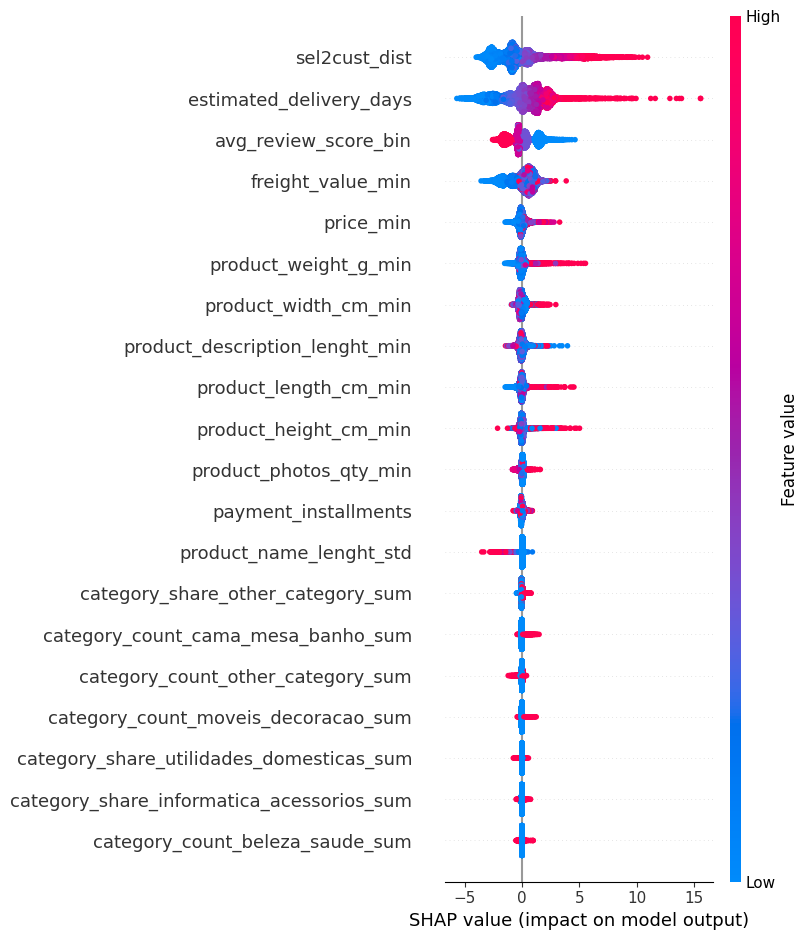

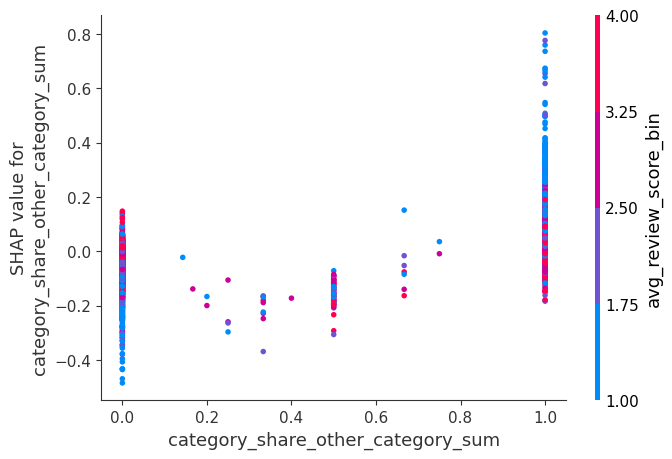

None


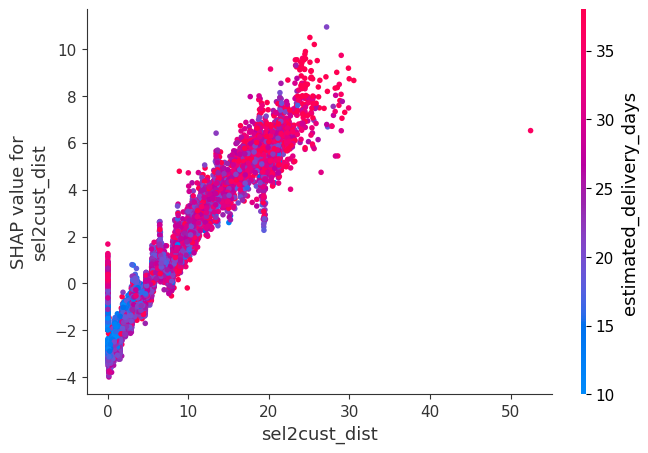

None


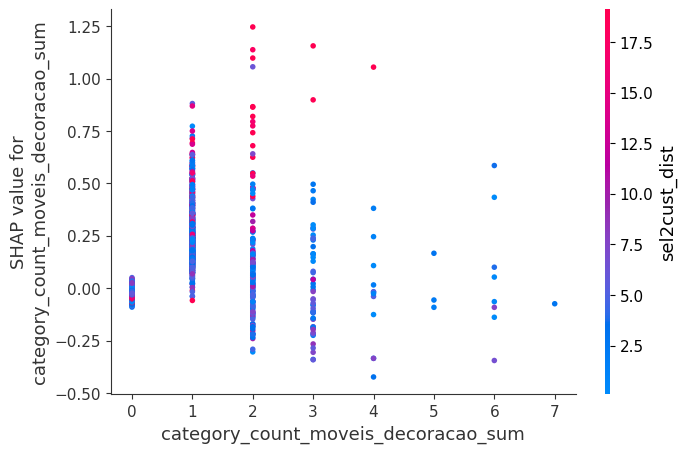

None


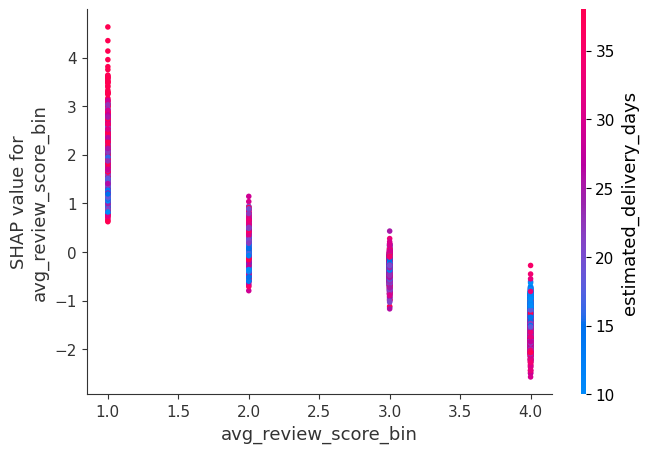

None


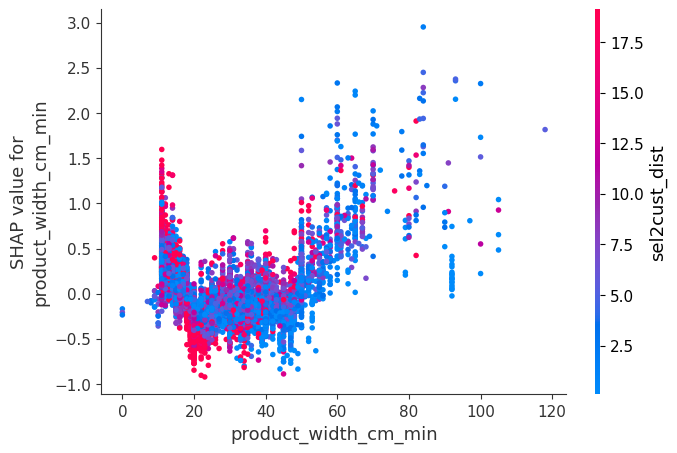

None


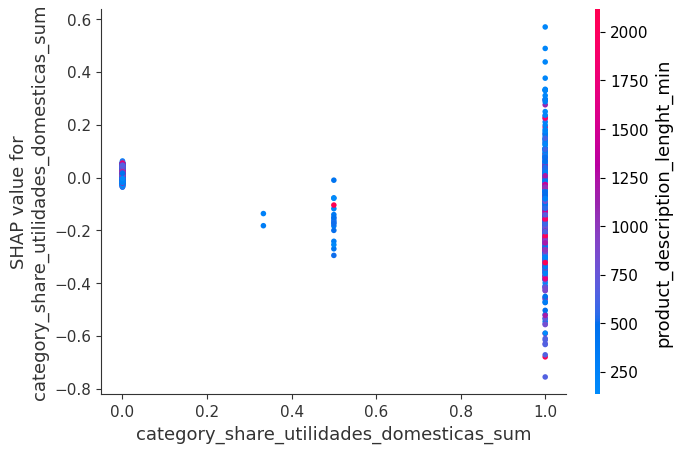

None


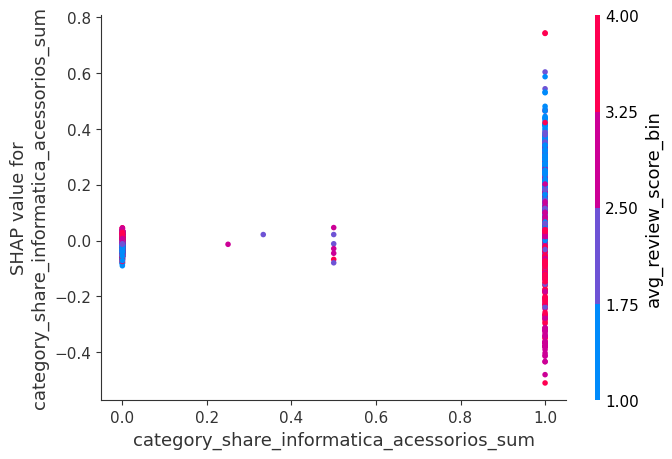

None


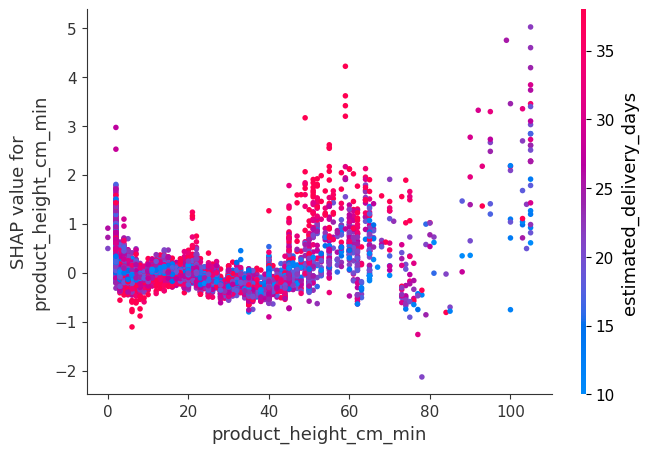

None


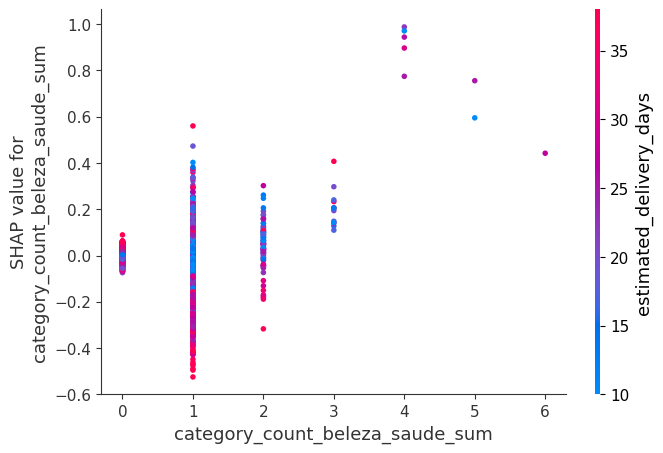

None


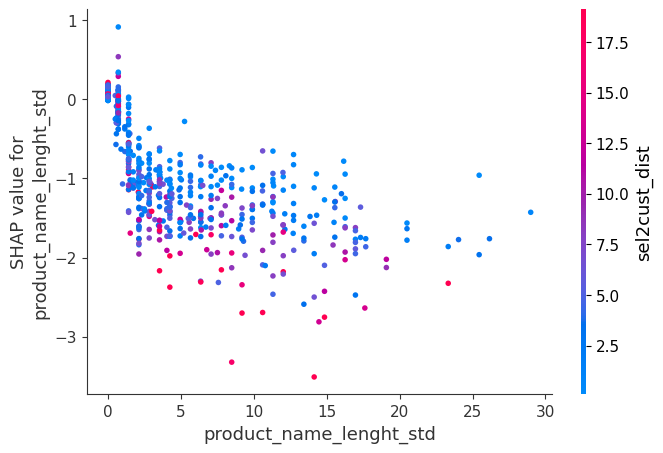

None


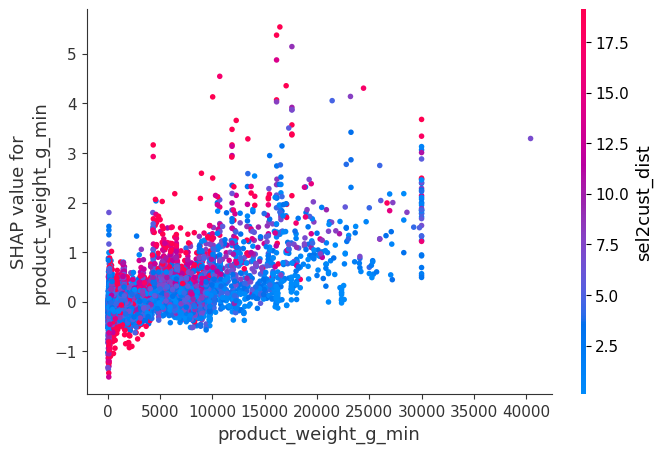

None


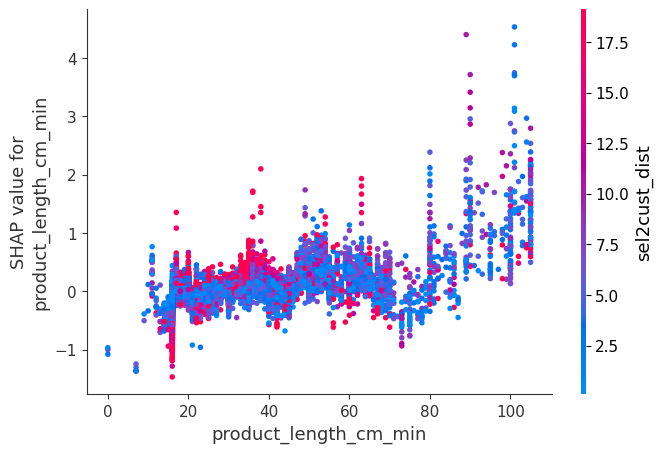

None


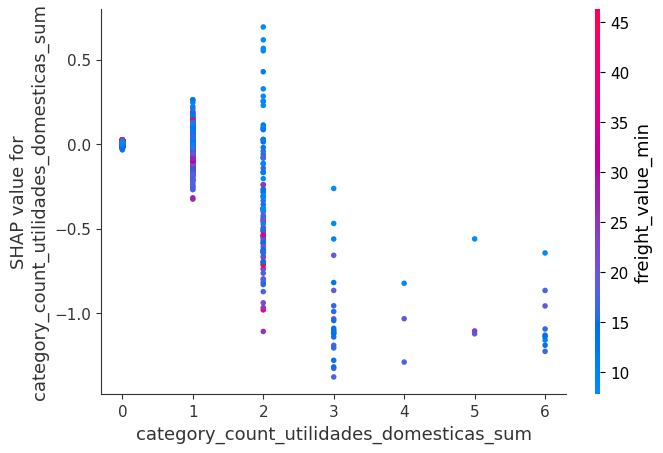

None


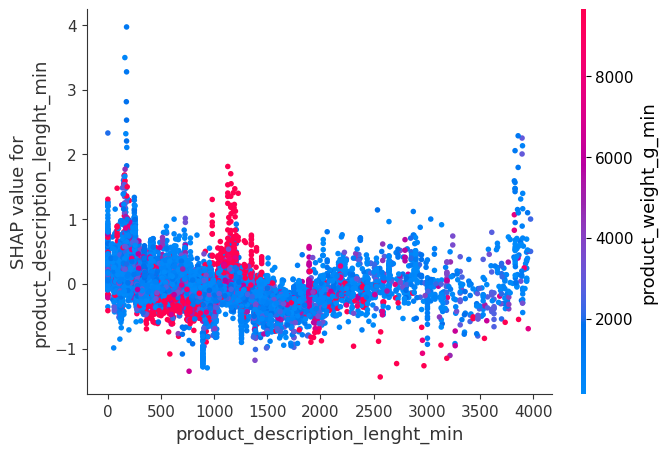

None


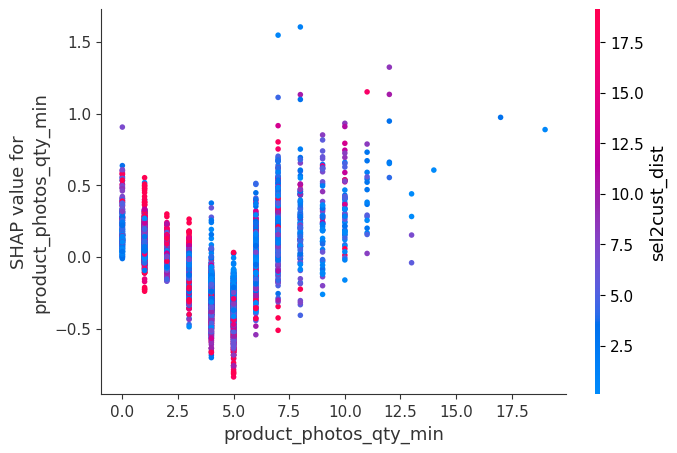

None


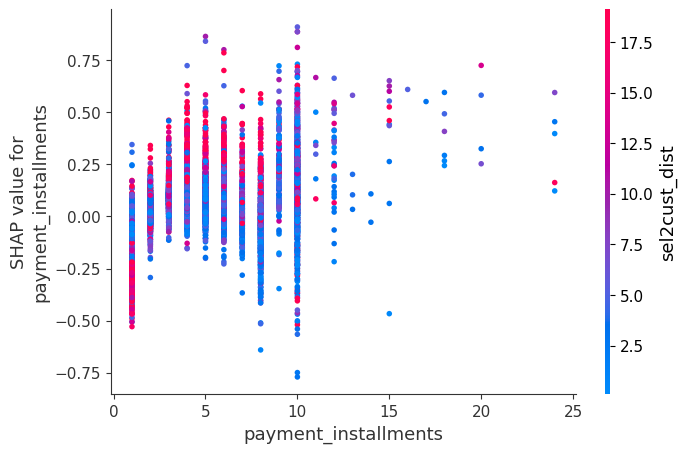

None


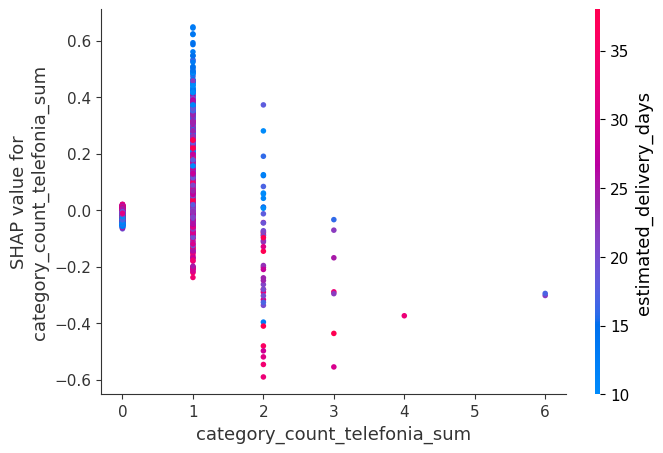

None


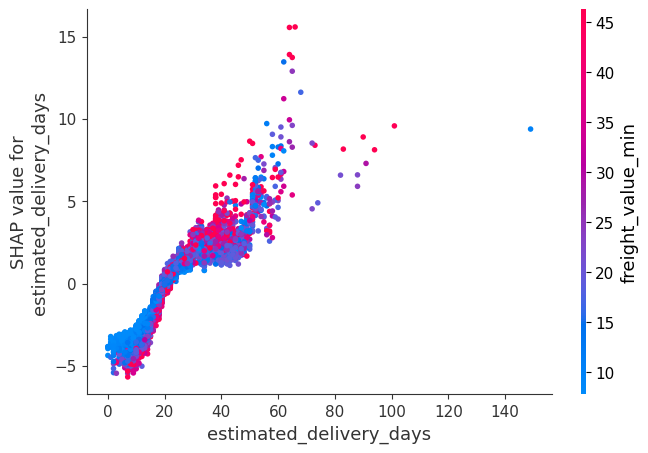

None


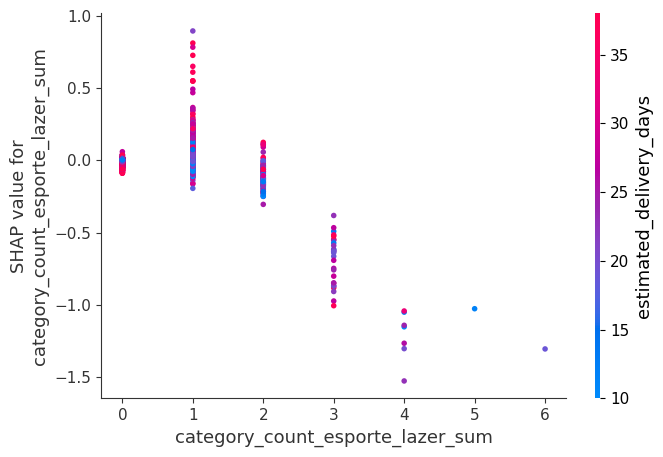

None


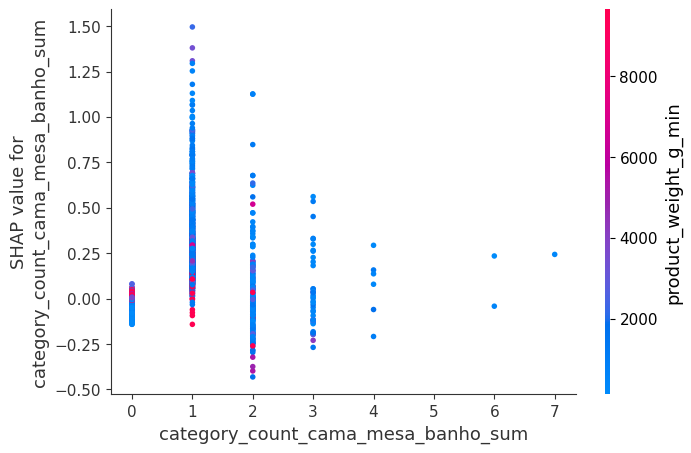

None


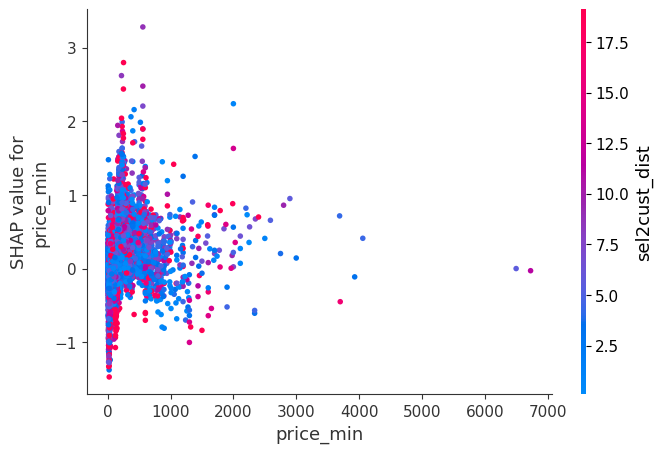

None


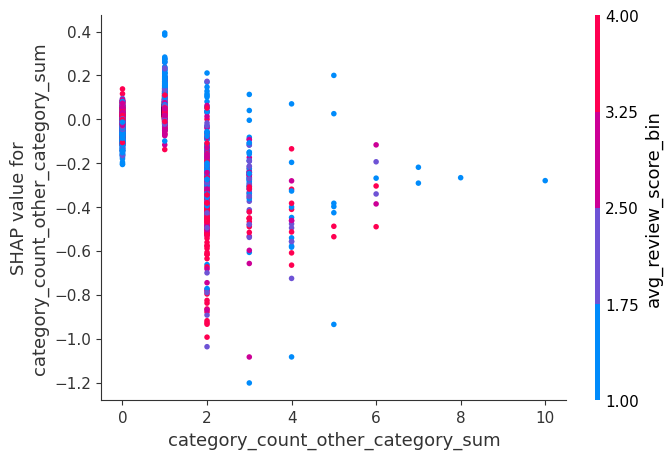

None


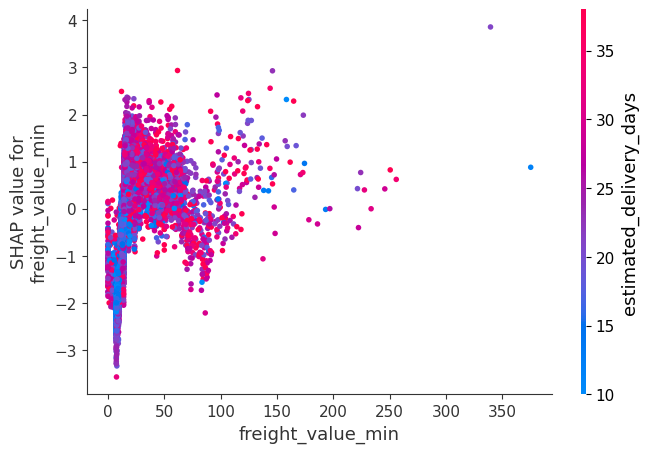

None


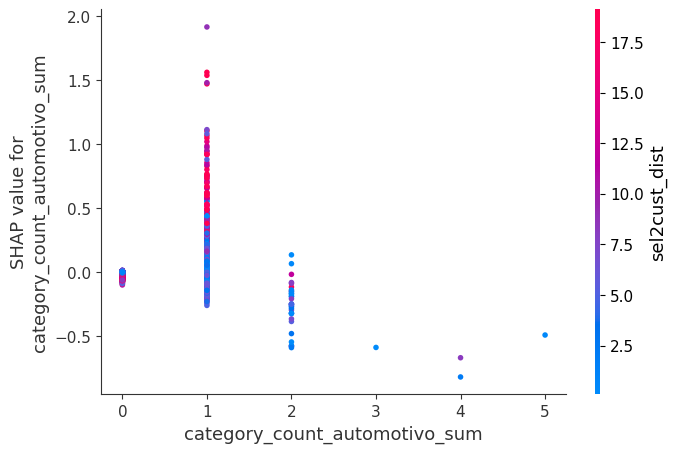

None


In [21]:
import shap  

explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

for c in X_test.columns:
    print(shap.dependence_plot(c, shap_values.values, X_test))